# Predicting the Urban Heat Island Effect in Singapore with Machine Learning

By: Delwyn Goh

Date Created: Feb 2025

## Introduction

The Urban Heat Island (UHI) effect is a phenomenon where the built-up areas in highly urbanized regions tend to exhibit higher temperatures than the rural areas. This is due to various factors such as reduced vegetation, high building density, and high population. The increased prevalence of UHI contributes to elevated energy consumption to escape the heat and other adverse health effects, and poses a challenge to sustainable urban development

In Singapore, UHI is prevalent in areas with high building density such as the Central Business District and surprisingly, despite its lower building density, Tai Seng. This analysis aims to determine the best Machine Learning model and features that predict Singapore's UHI intensity from 2009 to 2024.

Multiple steps were involved, from the installation and import of the necessary libraries, feature engineering, feature selection, pre-processing and finally building of the Machine Learning models.

By building this model, we hope to be able to uncover the underlying mechanisms of UHI, and provide insights on how we can make more informed urban planning decisions to enable us to mitigate the UHI effects and promote sustainable living within the urban city of Singapore.

The main data was collected from NEA's weather stations throughout Singapore. Meteorological data (temperature, wind, rainfall) was collected from 20 weather stations, and the Pulau Ubin Station was designated as the rural area that we will be using as the baseline to compare temperature against to get a measurement of UHI. 

Supplementary data on population (SingStat), building density (URA), forested area (NParks), electricity consumption (EMA) were collected as well to assist with the analysis.

## 1. Install and Import Libraries

In this section, we will install and import the required libraries needed for data manipulation, visualization, and modeling.

In [ ]:
# uncomment if need to install libraries

#!pip install pandas numpy matplotlib scikit-learn lightgbm xgboost

In [2]:
# Import libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt

## 2. Data Cleaning

In this section, we will check if there are any rows with null values, and drop them if necessary. We will also be checking the type of the features to ensure that they are the correct data type.

In [5]:
# Read data from csv
df = pd.read_csv("uhi_data_final.csv")

# Remove rows with null values
df = df.dropna()

# Confirm how many rows are left after dropping of missing values
print(df.shape)

# Bootstrapping to increase the number of samples
df = df.sample(n=len(df) * 5, replace=True, random_state=42)

(102034, 16)


In [6]:
#Check the data type for each feature
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 510170 entries, 15795 to 1146
Data columns (total 16 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Station         510170 non-null  object 
 1   Year            510170 non-null  int64  
 2   Month           510170 non-null  int64  
 3   Day             510170 non-null  int64  
 4   daily_rainfall  510170 non-null  float64
 5   mean_wind       510170 non-null  float64
 6   max_wind        510170 non-null  float64
 7   gpr             510170 non-null  float64
 8   forest          510170 non-null  float64
 9   Population      510170 non-null  int64  
 10  Units           510170 non-null  int64  
 11  elec_con        510170 non-null  float64
 12  Vehicles        510170 non-null  int64  
 13  humidity        510170 non-null  float64
 14  town_pop        510170 non-null  int64  
 15  uhi             510170 non-null  float64
dtypes: float64(8), int64(7), object(1)
memory usage: 66.2+

## 2. Feature Engineering

In this section, we will create new features from the existing dataset that are essential for our analyses. This step also includes creating dummy variables for categorical features and feature scaling.

### 2.1 Create dummy variables for categorical features (object data types)

We perform one-hot encoding for the categorical features in our dataset. This is required as most Machine Learning models require the data to be trained on to be in numerical form, and cannot take strings as an input.

In [10]:
# Create dummy variables for the Station Feature

df_test = pd.get_dummies(df)

### 2.2 Convert the dummy variables into boolean data types

In [12]:
# Ensure all boolean columns are dtype bool to prevent them from being scaled
def convert_to_boolean(df):
    for column in df.columns:
        if set(df[column].unique()) <= {True, False}:
            df[column] = df[column].astype(bool)
    return df

df_test = convert_to_boolean(df_test)

In [14]:
#Create unscaled uhi feature to calculate RMSE
df_test['unscaled_uhi'] = df_test['uhi']

### 2.3 Scale the numerical values
Feature scaling ensures that all factors contribute equally to the models performance, and there is no excess weightage assigned to features that have a higher magnitude.

In [16]:
# Scale the numerical values
scaler = StandardScaler()

def scale_numeric_columns(df, exclude_columns = ['unscaled_uhi']):
    num_cols = df.select_dtypes(include = ['int', 'float']).columns
    num_cols = num_cols.difference(pd.Index(exclude_columns))
    df[num_cols] = scaler.fit_transform(df[num_cols])
    return df

df_test = scale_numeric_columns(df_test)

## 3. Feature Selection

In this section, we select the features that we want to use in our model. By identifying the relevant features that  contribute the most to the model's performance, we can ensure that we get a Machine Learning model that performs the best.

This is an iterative process, and will be done multiple times to select the best features.

In [20]:
filtered_df = df_test[['unscaled_uhi','uhi',
                 "Month","Day","daily_rainfall","mean_wind", "max_wind",
                  "gpr","forest",
                  "humidity","Vehicles","town_pop",
                  "Station_Changi", "Station_Marina Barrage", "Station_Tengah"
                  ]]

## 4. Model Preprocessing

In this section, we prepare our dataset to ensure that it is ready to be fed into our Machine Learning model. Removal of outliers, checks for multicollinearity and creating the train-test split for Machine Learning will occur in this section. 

All these steps will help us to boost the performance of our Machine Learning model.

### 4.1 Removal of Outliers

Outliers will skew the performance of our model, and can lead to inaccurate predictions by the model. The Z-Score is used as a means to determine which are the outliers. 

As the data has already been scaled in step 2, we will be filtering out data that is above 3.0 or less than -3.0.

In [26]:
#Removal of outliers from our dataset. Z-Score <= -3.0 or >= 3.0
def exclude_outliers(filtered_df): 
    return filtered_df.apply(lambda col: col.map(lambda x: x if -3.0<= x <= 3.0 else None)).dropna()

df_cleaned = exclude_outliers(filtered_df)

In [27]:
#Check if there is an outstanding amount of outliers removed.
print(f"{(filtered_df.shape[0]-df_cleaned.shape[0])/filtered_df.shape[0]*100}%")

6.657192700472391%


### 4.2 Multicollinearity Check

We want to select features that are not highly correlated to each other. This step is essential as including features with high correlation with each other will mask the effect of those features on our model. 

If there are features that are highly correlated with each other (r >0.7), return to feature selection and drop one of the features from the model.

In [30]:
#Run a correlation matrix amongst the features

corr_matrix = df_cleaned.drop(columns = ['unscaled_uhi','uhi']).corr() 

multicollinearity_detected = False 

#Check if any values in the correlation matrix exceeds 0.7
#Returns features that have a correlation above 0.7
for column in corr_matrix.columns: 
    for row in corr_matrix.index: 
        if row != column and abs(corr_matrix.loc[row, column]) > 0.7: 
            print(f"The correlation between {row} and {column} is {corr_matrix.loc[row, column]}.") 
            multicollinearity_detected = True 

if multicollinearity_detected == False: 
    print("No multicollinearity detected.")

No multicollinearity detected.


### 4.3 Creating the Train-Test Split

We split our data into two, one on which to train our model upon, and the other to test our model against so that we can check the performance of the selected Machine Learning model. 

The chosen split for this analysis would be 75% Train data, and 25% Test Data

In [34]:
feature_columns = [column for column in df_cleaned.columns if column not in ['uhi', 'unscaled_uhi']]
X = df_cleaned[feature_columns]
y = df_cleaned["unscaled_uhi"]

In [35]:
#Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## 5. Modelling

In this section, we will be building 3 different Machine Learning models, and evaluate their performance. 

The selected models are variations of the Decision Tree model. Decision tree models split the data into subsets based on the most important features, and make a prediction based on the splits.

The selected models are:

<b> 1. Random Forest <br>
2. XGBoost <br>
3. LightGBM <br>
</b>

To evaluate the performance of each model, we will be using the $R^{2}$ value, RMSE, overfitting and run time. As a baseline, we will be aiming to get an $R^{2}$ value of above 0.8, an RMSE value of below 0.5. We will also be aiming to get the lowest overfitting between all the models (defined as the difference between the train and test $R^{2}$ values), and the fastest run time.

After building each model, we will also be checking the feature importance of each model to determine which features have the highest impact on our model's prediction. 

### 5.1 Random Forest

Random Forest builds an ensemble of decision trees that are trained upon different subsets of data and features. By averaging the outputs of all the trees, the model is able to come up with a prediction for UHI.

In [45]:
%%time
#Calculate the runtime of the Random Forest model

#Initialize and train the RandomForest regressor
rf_model = RandomForestRegressor(n_estimators=30, max_features = 'sqrt', random_state=42)
rf_model.fit(X_train, y_train)

#Make predictions on the training and test sets
y_train_pred = rf_model.predict(X_train)
rf_train_r2 = round(r2_score(y_train, y_train_pred),4)
rf_train_rmse = round(np.sqrt(mean_squared_error(y_train, y_train_pred)),4)

y_test_pred = rf_model.predict(X_test)
rf_test_r2 = round(r2_score(y_test, y_test_pred),4)
rf_test_rmse = round(np.sqrt(mean_squared_error(y_test, y_test_pred)),4)

print(f'Test size: {0.25}')
print(f'Train R2: {rf_train_r2}, Test RMSE: {rf_train_rmse}')
print(f'Test R2: {rf_test_r2}, Test RMSE: {rf_test_rmse}')
print(f'R2 Diff: {round(rf_train_r2 - rf_test_r2,4)}')
print('-----')

Test size: 0.25
Train R2: 0.9961, Test RMSE: 0.0403
Test R2: 0.9769, Test RMSE: 0.0975
R2 Diff: 0.0192
-----
CPU times: total: 10.2 s
Wall time: 12.1 s


#### Feature Importance

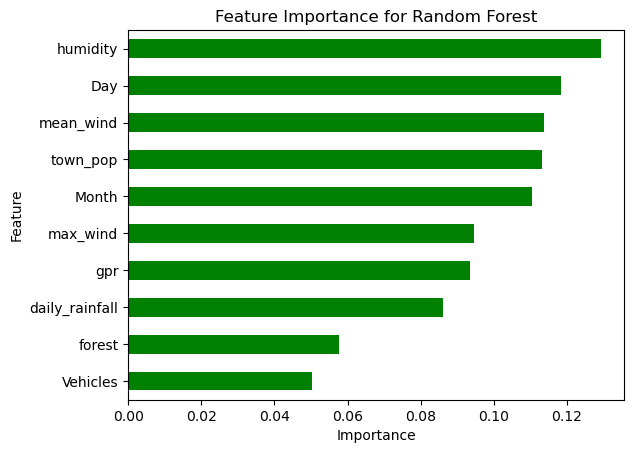

In [47]:
#Display the top 10 feature importances
feat_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
feat_importances = feat_importances.sort_values(ascending=True).tail(10)
feat_importances.plot(kind='barh', color = 'g')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Random Forest')
plt.show()

### 5.2 XGBoost

XGBoost is a form of gradient boosting, where decision trees are built sequentially, with each tree correcting the errors made by the previous tree. It builds each tree horizontally, and can result in longer run times.

In [50]:
%%time

xgb_model = xgb.XGBRegressor(objective = 'reg:squarederror', max_depth=7, learning_rate=0.1, n_estimators = 500)

xgb_model.fit(X_train, y_train)

y_pred_train = xgb_model.predict(X_train)
xgb_train_r2 = round(r2_score(y_train, y_pred_train), 4)
xgb_train_rmse = round(np.sqrt(mean_squared_error(y_train, y_pred_train)), 4)

y_pred_test = xgb_model.predict(X_test)
xgb_test_r2 = round(r2_score(y_test, y_pred_test), 4)
xgb_test_rmse = round(np.sqrt(mean_squared_error(y_test, y_pred_test)), 4)

print(f'Test size: {0.25}')
print(f'Train R2: {xgb_train_r2}, Test RMSE: {xgb_train_rmse}')
print(f'Test R2: {xgb_test_r2}, Test RMSE: {xgb_test_rmse}')
print(f'R2 Diff: {round(xgb_train_r2 - xgb_test_r2,4)}')
print('-----')


Test size: 0.25
Train R2: 0.6962, Test RMSE: 0.3548
Test R2: 0.6716, Test RMSE: 0.3677
R2 Diff: 0.0246
-----
CPU times: total: 6min 1s
Wall time: 26.5 s


#### Feature Importance

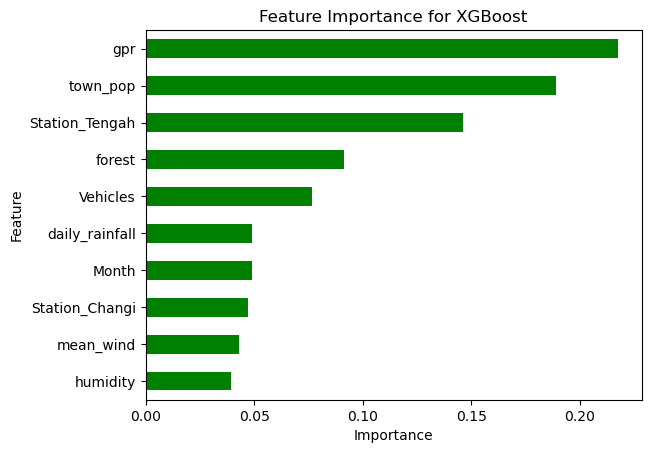

In [52]:
#Display the top 10 feature importances
feat_importances = pd.Series(xgb_model.feature_importances_, index=X.columns)
feat_importances = feat_importances.sort_values(ascending=True).tail(10)
feat_importances.plot(kind='barh', color = 'g')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for XGBoost')
plt.show()

### 5.3 LightGBM

LightGBM is another form of gradient boosting, where decision trees are built sequentially, with each tree correcting the errors made by the previous tree. It builds each tree leaf wise, and is much faster than XGBoost.

In [55]:
%%time

lgb_model = lgb.LGBMRegressor(n_estimators=1200, learning_rate=0.1, max_depth=10,  verbose=-1, random_state=42)

lgb_model.fit(X_train, y_train)

y_pred_train = lgb_model.predict(X_train)
lgb_train_r2 = round(r2_score(y_train, y_pred_train), 4)
lgb_train_rmse = round(np.sqrt(mean_squared_error(y_train, y_pred_train)), 4)

y_pred_test = lgb_model.predict(X_test)
lgb_test_r2 = round(r2_score(y_test, y_pred_test), 4)
lgb_test_rmse = round(np.sqrt(mean_squared_error(y_test, y_pred_test)), 4)

#print(f'Test size: {i}, Train R2: {lgb_train_r2}, Test R2: {lgb_test_r2}')
print(f'Test size: {0.25}')
print(f'Train R2: {lgb_train_r2}, Test RMSE: {lgb_train_rmse}')
print(f'Test R2: {lgb_test_r2}, Test RMSE: {lgb_test_rmse}')
print(f'R2 Diff: {round(lgb_train_r2 - lgb_test_r2, 4)}')
print('-----')


Test size: 0.25
Train R2: 0.7224, Test RMSE: 0.3391
Test R2: 0.6982, Test RMSE: 0.3525
R2 Diff: 0.0242
-----
CPU times: total: 22.7 s
Wall time: 4.72 s


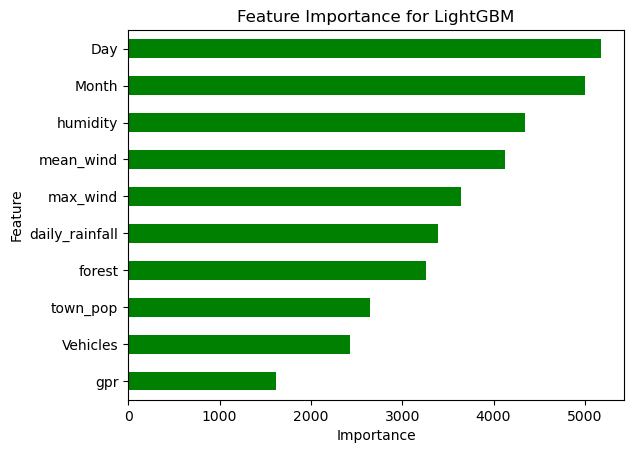

In [56]:
#Display the top 10 feature importances
feat_importances = pd.Series(lgb_model.feature_importances_, index=X.columns)
feat_importances = feat_importances.sort_values(ascending=True).tail(10)
feat_importances.plot(kind='barh', color = 'g')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for LightGBM')
plt.show()

## 6. Conclusions and Recommendations

In this analysis, we explored three different Machine Learning models to predict UHI in Singapore. By evaluating the different trade-offs between $R^{2}$, overfitting, RMSE and runtime, we have identified that <b><u>Random Forest</b></u> is the best model.

The performance of the models are as follows:
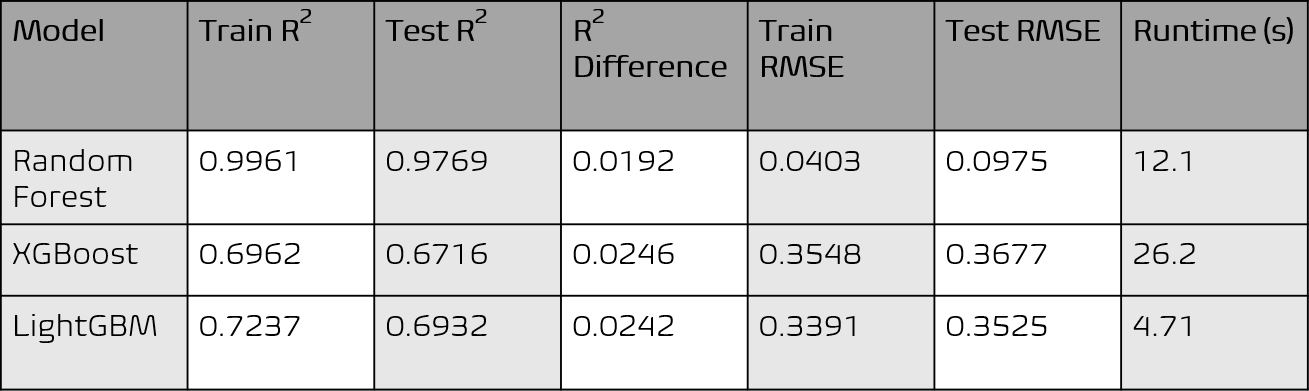

Random Forest proved to be the best performing model, with high $R^{2}$ values, low RMSE, low overfitting, and a reasonably quick runtime.

For the chosen model, the strongest predictors of UHI were:
- **Humidity**
- **Day and Month**
- **Wind Speed**
- **Town Population**
- **Gross Plot Ratio**
- **Rainfall**
- **Forest Coverage**

These predictors are factors that we should target when trying to reduce UHI in Singapore. While some factors might be out of our control such as rainfall and date, we can introduce sustainable urban planning decisions that will help to reduce UHI.

Possible solutions include:
- Design buildings that align with the prevailing wind directions
- Introduction of more parks and forested areas
- Introducing more urban greenery such as vertical planting and rooftop gardens

The model that was developed in this notebook can serve as a indicator on which are the factors that contribute to UHI in Singapore, and can be used to help ensure that we are able to live comfortably within a sustainable urban city.